## BIKE SHARING DEMAND COMPETITION

#### Source: Kaggle | Date: 11/26/18 

#### Overview
Predict Bike Sharing Demand on days 20th-to-end-of-month using hourly training data for days 1-19 of the month. **Only information available prior to the rental period can be used to predict demand.**

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## 1. Load Libraries and Datasets

First, all required libraries are loaded.

In [5]:
# General
import warnings
from datetime import datetime
from datetime import timedelta
import os

# Data Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Linear Regression
import statsmodels.api as sm
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error
import statsmodels.formula.api as smf

# Neural Networks
from keras.models import Model
from keras import Input, layers

# Random Forests
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

# XGBoost
import xgboost as xg
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

%matplotlib inline 
#to show images within Jupyter Notebook without having to call "show()"

C:\Users\dbejarano\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Load train datasets and sample submission file already saved in directory. Below are the first few rows for each.

In [102]:
# Load Datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sampleSubmission.csv')

# Visualize Datasets as Tables
display(train_df.head(3))
print('Training Set Size: ', train_df.shape)
display(test_df.head(3))
print('Test Set Size: ', test_df.shape)
display(sample_submission.head(3))

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


Training Set Size:  (10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000


Test Set Size:  (6493, 9)


,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0


### Datasets Description

#### Features:
- datetime - hourly date & timestamp <br>
- season - 1 = spring, 2 = summer, 3 = fall, 4 = winter <br>
- holiday - 1 = holiday, 0 = non-holiday<br>
- workingday - 1 = working day, 0 = weekend <br>
- weather
    1. Clear, Few clouds, Partly cloudy, Partly cloudy
    2. Mist & Cloudy, Mist & Broken clouds, Mist & Few clouds, Mist
    3. Light Snow, Light Rain & Thunderstorm & Scattered clouds, Light Rain & Scattered clouds
    4. Heavy Rain & Ice Pallets & Thunderstorm & Mist, Snow & Fog
<br>
- temp - temperature in Celsius<br>
- atemp - "feels like" temperature in Celsius<br>
- humidity - relative humidity<br>
- windspeed - wind speed<br>
- casual - number of non-registered user rentals initiated<br>
- registered - number of registered user rentals initiated<br>
- count - number of total rentals (Dependent Variable)<br>

Variable names are all-lower-case. However, throughout this document I will use upper-case for the first letter, so it's obvious that I'm referring to the variables in question (e.g. Holiday, Weather, etc).

#### Training Set:
Contains 10,886 observations of 12 variables. The dependent variable (what we will be predicting) is the feature Count. It contains hourly observations for days 1-19 of every month from 2011-01-01 to 2012-12-19.

#### Test Set:
Contains 6,493 observations of 9 variables. It includes hourly observations for days 20-end_of_month from 2011-01-20 to 2012-12-31.

It does not include the Casual and Registered features (divides renters into registered and non-registered users). Since we won't be able to use them to predict on the testing set, and since Count is lineraly dependent on them (Count = Casual + Registered) we will be dropping them as they won't be of much help in our predictions.

#### Sample Submission:
We will be predicting the count of bicycles rented per hour on the test set.

### Data Types
Let's look at what type of variables we are dealing with in our datasets. 

We notice for the most part is numeric. Some of those numeric variables are categorical ones represented as integers: Season, Holiday, Workingday and Weather

In [6]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB
None


## 2. Exploratory Data Analysis (EDA) 

Let's first look at a pairplot of the variables to get a feel for what the dataset contains. I already show it with Casual and Registered features dropped. Also, Atemp is very highly correlated w/ Temp, so it was dropped as well to avoid multicolinearity.

**REMEMBER that ONLY the training set should be used during EDA. This prevents us from learning information about the test set that could bias us to reach particular conclusions that are specific to the test set and would not necessarily generalize well.**

### Feature Engineering - Part 1
Remove Casual, Registered and Atemp are dropped from the training and test sets.

In [103]:
undesired_feat1 = ['casual', 'registered', 'atemp']
train_df.drop(undesired_feat1, inplace=True, axis=1)

### Visualization - Pair Plots

C:\Users\dbejarano\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\dbejarano\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\dbejarano\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\dbejarano\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


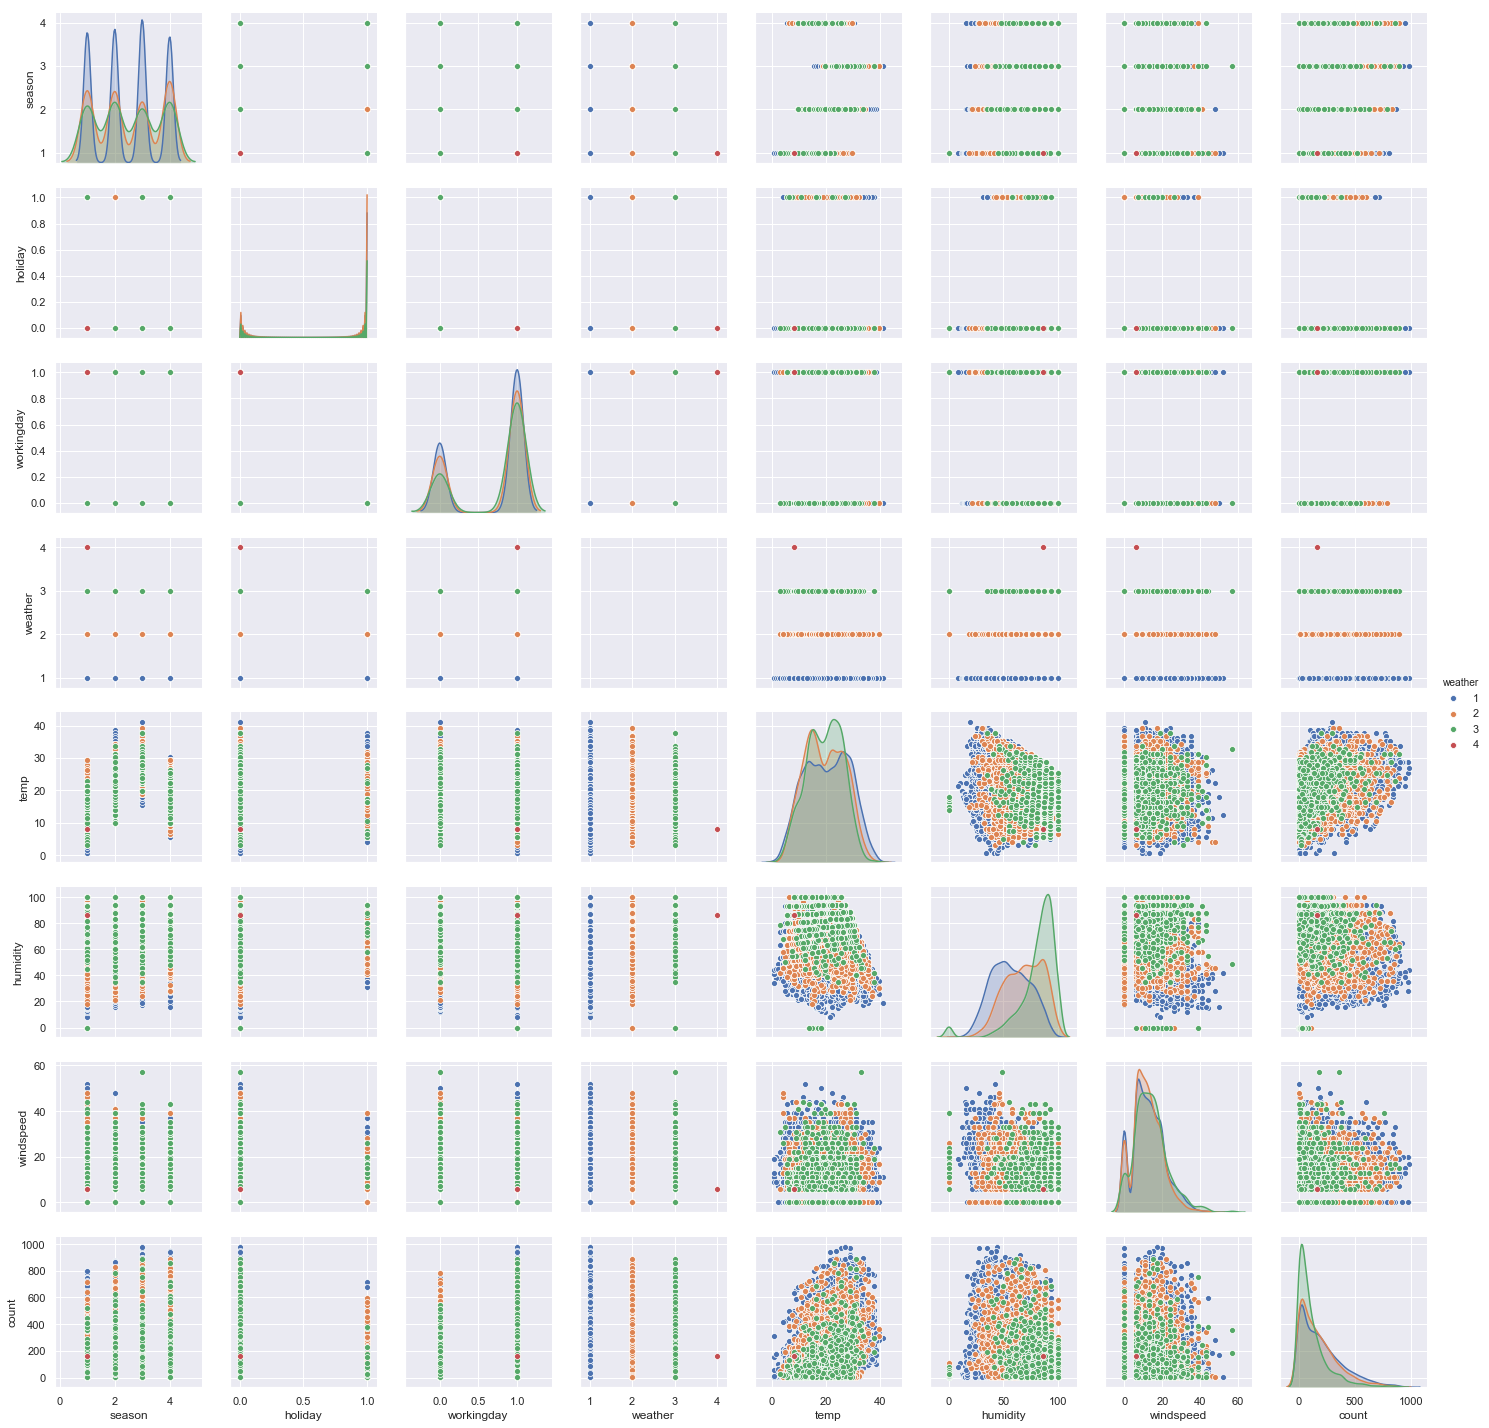

In [104]:
sns.set()
sns.pairplot(train_df, hue='weather')
warnings.simplefilter('ignore')

#### Analysis:

1. Count is skewed right. Since a good amount of statistical models assume a Gaussian distribution we will try a some transformations to normalize the data
2. Temp and Winspeed seem to have a positive and negative correlation with Count, respectively.
3. There is not such a considerable difference between workinday and weekday ridership. It does seem to depend on the weather, where most of the cloudy day ridership occurs on the weekends and holidays.

One thing that is not present in our pairs plot is Datetime. Let's extract its components into new columns

### Feature Engineering - Part 2
Datetime is converted from a string into a datetime object.

In [105]:
# Change Datetime to date and time values and make datetime the axis
train_df['datetime'] = train_df['datetime'].apply(lambda x:datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

# Add columns for month, hour, day and year
train_df['year'] = train_df.datetime.apply(lambda x: x.year)
train_df['month'] = train_df.datetime.apply(lambda x: x.month)
train_df['day'] = train_df.datetime.apply(lambda x: x.day)
train_df['hour'] = train_df.datetime.apply(lambda x: x.hour)
train_df['weekday'] = train_df.datetime.apply(lambda x: x.weekday())

# Set datetime as the index
train_df.set_index('datetime', inplace=True)

train_df.head(2)

,season,holiday,workingday,weather,temp,humidity,windspeed,count,year,month,day,hour,weekday
datetime,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,81,0.0,16,2011,1,1,0,5
2011-01-01 01:00:00,1,0,0,1,9.02,80,0.0,40,2011,1,1,1,5


### Visualization of Count
Get an understanding of how Count relates to other variables

#### Rolling Sum Over 24 Hours

(734138.0, 734856.9583333334)

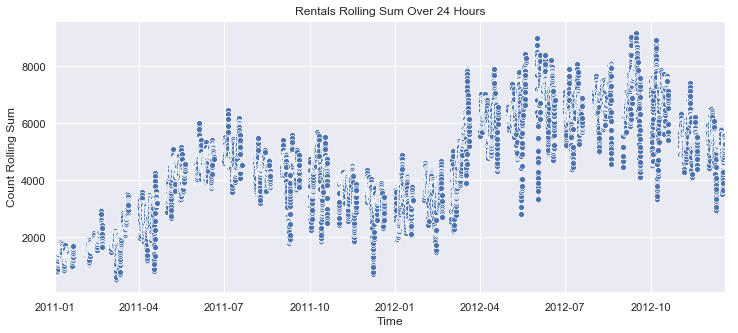

In [146]:
fig,ax = plt.subplots()
fig.set_size_inches(12,5)
sns.scatterplot(x = train_df.index, y = train_df['count'].rolling(24).sum())
ax.set(ylabel='Count Rolling Sum', xlabel='Time', title='Rentals Rolling Sum Over 24 Hours')
ax.set_xlim(train_df.index.min(), train_df.index.max())

#### Analysis:
Count cycles during each month, as well as by season, but it also shows a clear increasing tendency overall with time.

#### Count Outliers

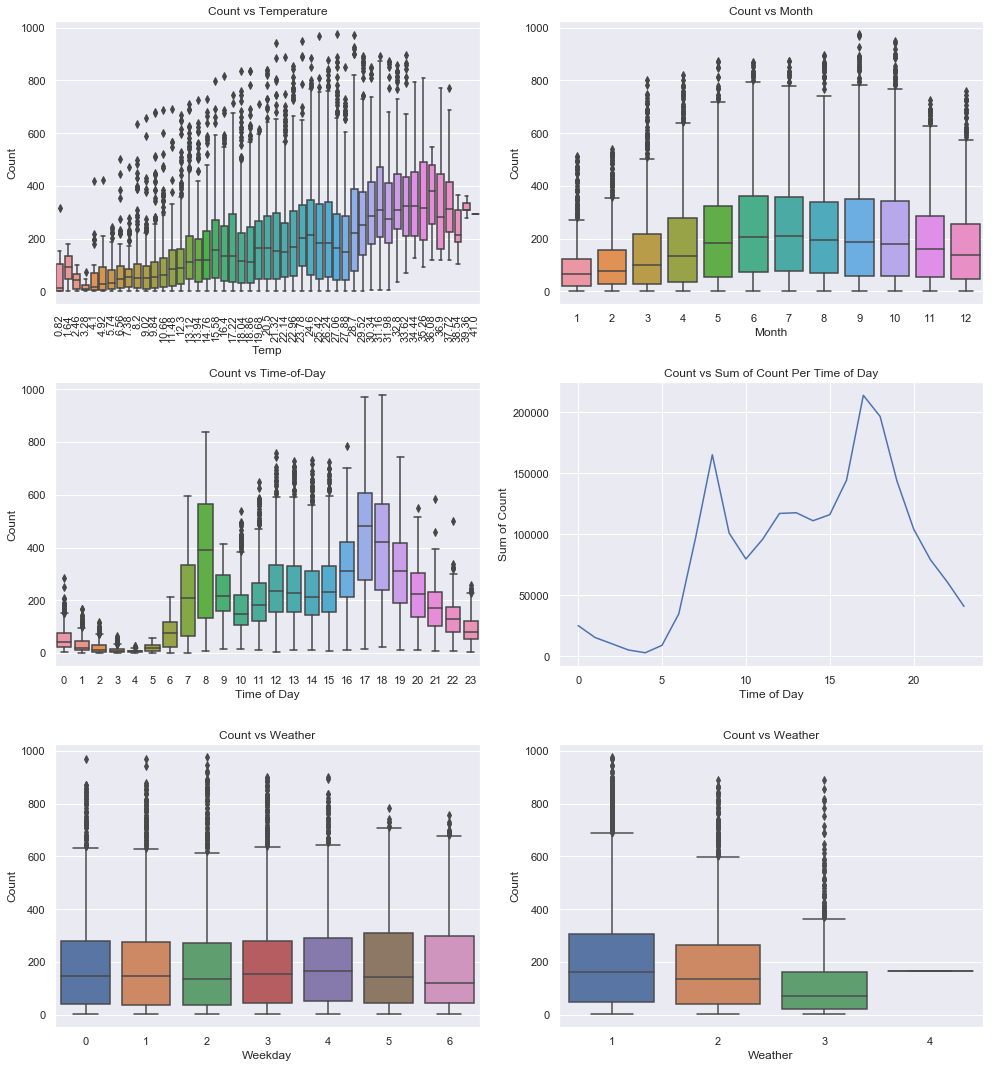

In [107]:
fig, axes = plt.subplots(nrows=3,ncols=2)
fig.set_size_inches(14, 15)

# As a function of time of day
sns.boxplot('temp', 'count', data=train_df, ax=axes[0][0])
axes[0][0].set(ylabel='Count', xlabel='Temp', title='Count vs Temperature')
for item in axes[0][0].get_xticklabels():
    item.set_rotation(90)
    
# As a function of month
sns.boxplot('month', 'count', data=train_df, ax=axes[0][1])
axes[0][1].set(ylabel='Count', xlabel='Month', title='Count vs Month')

# As a function of hour in the day
sns.boxplot('hour', 'count', data=train_df, ax=axes[1][0])
axes[1][0].set(ylabel='Count', xlabel='Time of Day', title='Count vs Time-of-Day')

# As a function of the day of the month
sum_count_per_hour = pd.DataFrame(train_df.groupby('hour')['count'].sum()).reset_index()
sns.lineplot(x='hour', y='count', data=sum_count_per_hour, ax=axes[1][1])
axes[1][1].set(ylabel='Sum of Count', xlabel='Time of Day', title='Count vs Sum of Count Per Time of Day')

# As a function of day of the week
sns.boxplot(x='weekday', y='count', data=train_df, ax=axes[2][0])
axes[2][0].set(ylabel='Count', xlabel='Weekday', title='Count vs Weather')

# As a function of weather
sns.boxplot('weather', 'count', data=train_df, ax=axes[2][1])
axes[2][1].set(ylabel='Count', xlabel='Weather', title='Count vs Weather')

plt.tight_layout() # to leave some space between graphs

#### Analysis:

1. Rentals show a tendency to increase with higher temperatures, up to about 36 deegres-C.
2. More rentals occur during the Spring and Summer months.
3. From the features presented above, the one offering the largest variance amongst its values is Hour. It can be inferred that most rentals are for people to commute to work since the average rentals at 8 AM and 5 PM are the highest. The line plot, however, does show that the cummulative rentals between 11 AM and 8 PM are high enough to conclude that there is considerable non-commuting renting throughout the day, but it's less predictable, as can be seen by the large number of outliers between 10 AM and 3 PM.
4. On average, rentals are faily uniform from one day of the week to the next.
4. One assumption we could make is that a significant amount of users have alternative commmuniting options, since commuting is a big part of rentals, and the average Count drops considerably from good to bad weather. We will explore this later. 
5. Based on the amount of outliers, it might make sense to remove the most extreme values.

#### Let's see if the same outliers and distributions can be observed by re-scaling Count.

#### Count Distribution


[Text(0.5,1,'Modified Distribution')]

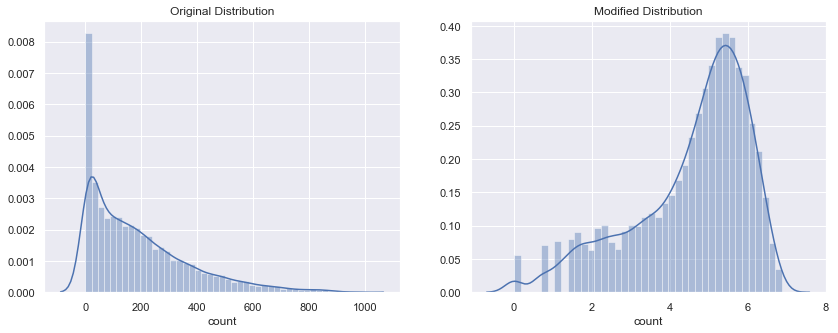

In [109]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(14, 5)

sns.distplot(train_df['count'], ax=axes[0])
axes[0].set(title='Original Distribution')

# Define Data Variations
log_count = np.log(train_df['count'])
x_p5 = np.sqrt(train_df['count'])

sns.distplot(log_count, ax=axes[1])
axes[1].set(title='Modified Distribution')

#### Analysis:
The data is skewed to the right. After attempting several transformations (such as x^1/2, x^1/3) a log transformation provides a distribution that looks fairly Gaussian in comparison w/ the original

### Feature Engineering - Part 3: Outliers and Data Transformation

This will consist of two parts:
1. Remove outliers - We will define outliers as those points beyond the 99 percentile, which is 3 standard deviations from the mean.
2. Substitute Count with its log transformation: log(count).

One needs to be cautious when removing outliers. Just because it's an extreme value doesn't mean it's an error or that it's not informative. When doing data INFERENCE, we seek to understand the dependent and independent variables as much as possible, and their relationship. When the focus is PREDICTION, the goal is developing a model that predicts accurately on unseen data. In this case our interest is a little on the former, but more so on the latter, so we will proceed to test our model with and without outliers. 

Transformations may not always provide benefits either, so we will try fitting a model with and without the data transformation as well. 

In [111]:
# Keep both log_count and count in dataset to be able to go back and forth for intepretability
train_df['log_count'] = np.log(train_df['count']) 

# Remove Outliers
count_mean = np.mean(train_df['count'])
count_std = np.std(train_df['count'])
three_std = count_mean + 3*count_std

train_df = train_df[train_df['count'] < three_std]

### Correlation Analysis

To make our colinearity (when two or more predictors are closely related to each other) analysis more robust, we create and examine a correlation matrix.

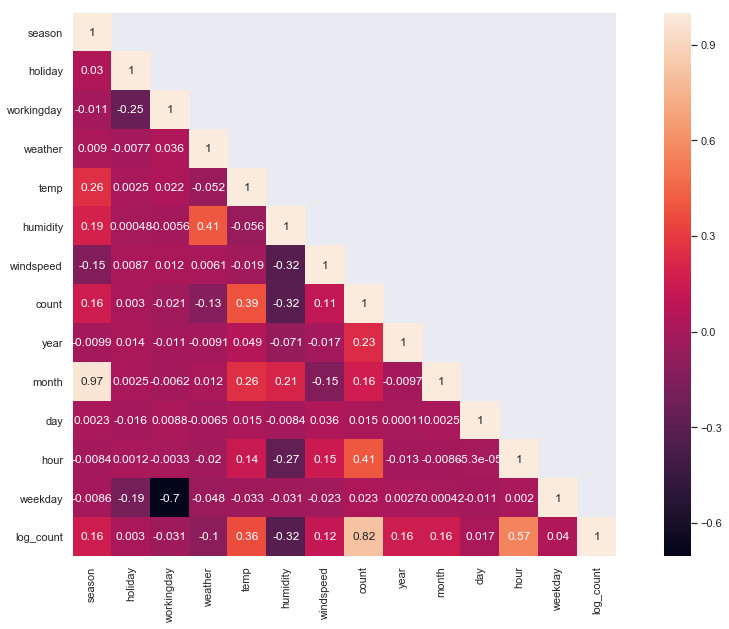

In [112]:
mask = np.array(train_df.corr())
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(17,10)
sns.heatmap(train_df.corr(), mask=mask, square=True,annot=True)

#### Deductions
There are only a few variables with high correlation. Some are not very interesting, like Month being highly correlated with Season, or Humidity being correlated with Weather.

Others, however, might be less obvious and more relevant. First, Count correlates at 0.39 with Temp. Another is how Count correlates with Hour. Even more surprising is that Log_count is highly correlated with Hour. It looks like the data transformation may have turned some of these predictors into more powerful ones. 

### Some Remaining Questions

Some questions that came up to me during the analysis done so far:

1. How does Count vary depending on the day of the week?
2. Are there times during the year when more percentage of the bike rentals are on a workday vs the weekend?
3. How much does Temp affect Count throughout the day?
    - To answer this question we need to convert Temp into a categorical variable: We into 4 segments: 0-10 ,11-20, 21-30, 31-max
4. How would each of this differ between Count and Log_Count?
    - The answer to this question is that the relative change between weather types, workingday, and Temp remain after transforming the data. Being that Count is easier to interpret than Log_Count, we will only plot Count. 

Let's plot those relationships mentioned above to come up with some insights.

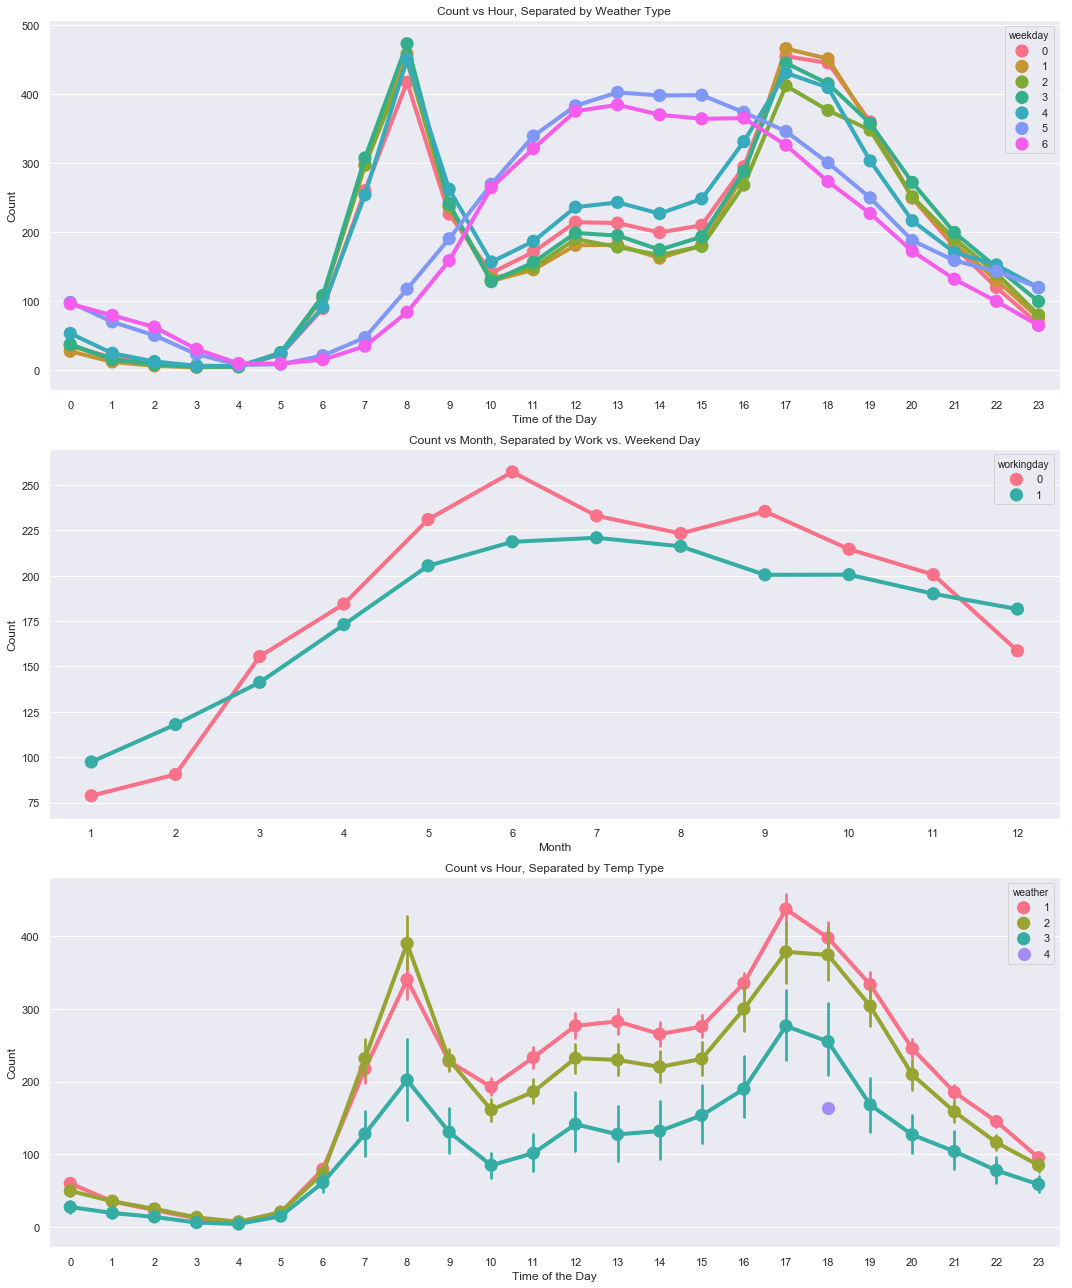

In [254]:
fig,axes = plt.subplots(nrows=3, ncols=1)
fig.set_size_inches(15, 18)

# Question 1:
# 0=Monday, 6=Sunday
day_of_week = train_df.groupby(['weekday', 'hour'], sort=True).mean().reset_index()
sns.pointplot(x='hour', y='count', data=day_of_week, hue='weekday', join=True, ax=axes[0], scale=1.5, palette='husl')
axes[0].set(xlabel='Time of the Day', ylabel='Count', title='Count vs Hour, Separated by Weather Type')

# Question 2:
yearly_workingday = train_df.groupby(['workingday', 'month'], sort=True).mean().reset_index()
sns.pointplot(x='month', y='count', data=yearly_workingday, hue='workingday', join=True, ax=axes[1], scale=1.5, palette='husl')
axes[1].set(xlabel='Month', ylabel='Count', title='Count vs Month, Separated by Work vs. Weekend Day')

# Question 3: 
# cat_temp = pd.cut(train_df['temp'], 4, labels=["cold", "cool", "warm", "hot"])
# train_df['cat_temp'] = cat_temp
hourly_temp = train_df.groupby(['weather', 'hour'], sort=True).mean().reset_index()
sns.pointplot(x='hour', y='count', data=train_df, hue='weather', join=True, ax=axes[2], scale=1.5, palette='husl')
axes[2].set(xlabel='Time of the Day', ylabel='Count', title='Count vs Hour, Separated by Temp Type')

plt.tight_layout() # to leave some space between graphs

#### Analysis:
1. As previously observed, during the week most of the rentals are customers commuting to/from work. The weekend shows high rentals throghout mid-day and into the afternoon.
2. Hourly rentals vary on different months of the year, but they are not very different between working and non-working days. We do see a trend that more "recreational" rides (non-working days) occur during the summer when compared to workingday rentals. The opposite is true during the winter.
3. Weather seems to affect rentals uniformly regardless of the time of the day. The extreme cases are when rentals are very low and when they are very high. The gaps between good and bad weather rentals are smaller/larger at those points in time, respectively.

**The EDA above should be sufficient to give us an idea of how variables relate to each other, especially how Count relates to the rest. This information is highly important when choosing the model, doing feature selection or any other type of feature engineering, and when analyzing the results from our models.**

**Before we move on to modeling, let's define functions for pre-processing data to get it in the appropriate form for our models. We will use functions since we might want to use different pre-processing steps for different models, and since we will do this both for our train and test sets. Functions will therefore save time and avoid confusion.**

## 3. Data Preprocessing

### Define functions to Preprocess Data

In [3]:
def load_datasets(file_names):
    '''loads a list of files as pandas dataframes'''
    files_list = []
    for i in file_names:
        df_i = pd.read_csv(i)
        files_list.append(df_i)
    return(files_list)

def drop_features(df, features):
    '''Drop specified list of features'''
    df.drop(features, inplace=True, axis=1)
    return(df)

def process_datetime(df):
    '''Change Datetime to date and time values, set those values as columns, and
    set original datetime column as index'''
    df['datetime'] = df['datetime'].apply(lambda x:datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    # Add columns for month, hour, day and year
    df['year'] = df.datetime.apply(lambda x: x.year)
    df['month'] = df.datetime.apply(lambda x: x.month)
    df['day'] = df.datetime.apply(lambda x: x.day)
    df['hour'] = df.datetime.apply(lambda x: x.hour)
    df['weekday'] = df.datetime.apply(lambda x: x.weekday())
    df.set_index('datetime', inplace=True)
    return(df)

def log_transform(df):
    '''Keep both log_count and count in dataset to be able to go back and 
    forth for intepretability'''
    df['count'] = np.log(df['count']) 
    return(df)

def remove_outliers(df):
    '''Remove Outliers'''
    count_mean = np.mean(df['count'])
    count_std = np.std(df['count'])
    three_std = count_mean + 3*count_std
    df = df[train_df['count'] < three_std]
    return(df)

def norm_scale(df, cont_features):
    '''Normalize and Scale Continuous Features'''
    df[cont_features] -= np.mean(df[cont_features])
    df[cont_features] /= np.std(df[cont_features])
    return(df)

def cat_into_one_hot(df, cat_features):
    '''Takes list of categorical features and turns them into One-Hot Encoding'''
    df = pd.get_dummies(df, columns=cat_features, drop_first=True)
    return(df)

def split_train_val(df, val_size):
    '''Separates the training set into a training and a validation set
    val_size should be a number between 0 and 1'''
    split_at = int(df.shape[0] // (1/(1-val_size)))
    df_train = df[:split_at][:]
    df_val = df[split_at:][:]
    return(df_train, df_val)
    
def split_x_y(df_train, df_val):
    '''Takes a training set and a validation set and returns X_train, y_train, X_val, y_val'''
    x_train_df = df_train.drop('count', axis=1)
    y_train_df = df_train['count']
    x_val_df = df_val.drop('count', axis=1)
    y_val_df = df_val['count']
    return(x_train_df, x_val_df, y_train_df, y_val_df)

def exp_transform(df):
    '''To convert Count back to non-log values'''
    if type(df) == pd.core.series.Series:
        df = np.exp(df)
    elif type(df) == np.ndarray:
        df = np.exp(df)
    else:
        df['count'] = np.exp(df['count'])
    return(df)

Let's load and preprocess the data. The end result will be what we walked through on the EDA section above, with 3 major additions: 
1. All categorical variables (those which can only take on discrete values, whether they come in numerical or string form) will be converted to one-hot-encodings. This is highly recommended for certain ML algorithms because, say, for Season, a value of 4 does not mean anything in relation to a value of 1 other than the fact they are two different categories. The fact that winter is 4 does not mean it's 4 times larger than spring. 
2. We will perform normalization and standardization of features before inputting them into some of the models. Neural Networks, for instance, are particularly sensitive to features in different scales. This is reasonable the features are normally distributed, which in this case it's not true for all.
3. Our training dataset will be split into X_train, X_val, y_train and y_val.

### Data Preprocessing for train and test sets
These functions should take the input data and transform it to a form that can be fed into the various predictive models we will fit.

In [6]:
# Load Datasets
train_df, test_df = load_datasets(['train.csv', 'test.csv'])
sample_submission = pd.read_csv('sampleSubmission.csv')

# Drop Uninportant Features
train_df = drop_features(train_df, ['casual', 'registered', 'atemp'])
test_df = drop_features(test_df, 'atemp')

# Process Datetime
train_df = process_datetime(train_df)
test_df = process_datetime(test_df)

# # Remove Outliers - Only for Training Data
# train_df = remove_outliers(train_df)

# Normalize and Standardize Continuous Variables
cont_features = ['temp', 'humidity', 'windspeed']
train_df = norm_scale(train_df, cont_features)
test_df = norm_scale(test_df, cont_features)

# # Transform Data to Log - Only for Training Data
# train_df = log_transform(train_df)

# Change Categorical into One_Hot - 'day' is not included bc it's different between train & test
cat_features = ['season', 'holiday', 'workingday', 'weather', 'month', 'hour', 'weekday']
train_df = cat_into_one_hot(train_df, cat_features)
test_df = cat_into_one_hot(test_df, cat_features)

# Split into train train and validation sets
train_train_df, train_val_df = split_train_val(train_df, 0.2)

# Split into X and y
X_train, X_val, y_train, y_val = split_x_y(train_train_df, train_val_df)

# Check datasets shapes
print('We check the datasets shapes to ensure our pre-processing function did its job correctly: ', '\n')
print('X_train Shape: ', X_train.shape)
print('X_val Shape: ', X_val.shape)
print('y_train Shape: ', y_train.shape)
print('y_val Shape: ', y_val.shape)
print('Test Set Shape: ', test_df.shape)

We check the datasets shapes to ensure our pre-processing function did its job correctly:  

X_train Shape:  (8708, 53)
X_val Shape:  (2178, 53)
y_train Shape:  (8708,)
y_val Shape:  (2178,)
Test Set Shape:  (6493, 53)


## 4. Predictive Data Analytics (PDA)

### Model A: Liner Regression

In the code we can observe that copies of the datasets were made, in case we want to make some alterations, like dropping features that are not predictive enough. This way we can quickly test performance of the model on differently featured engineered sets.


In [62]:
X_train_lr = X_train.copy()
y_train_lr = y_train.copy()
X_val_lr = X_val.copy()
y_val_lr = y_val.copy()

feats_to_drop = ['weather_4', 'month_4', 'weekday_1', 'weekday_2']
X_train_lr.drop(feats_to_drop, inplace=True, axis=1)
X_val_lr.drop(feats_to_drop, inplace=True, axis=1)

X_train_lr_intercept = sm.add_constant(X_train_lr, has_constant='add') # this adds an intercept term column
est = sm.OLS(y_train_lr, X_train_lr_intercept) 
est2 = est.fit()
X_val_lr_intercept = sm.add_constant(X_val_lr, has_constant='add')
pred_lr = est2.predict(X_val_lr_intercept)
print(est2.summary())

# Convert back from Log_Count to Count
pred_lr = exp_transform(pred_lr)
y_val_lr = exp_transform(y_val_lr)

# Evaluate Model
pred_lr[pred_lr<0] = 0
msle = np.sqrt(mean_squared_log_error(y_val_lr, pred_lr))
print('MSLE: ', msle)

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     896.7
Date:                Fri, 30 Nov 2018   Prob (F-statistic):               0.00
Time:                        20:13:47   Log-Likelihood:                -8226.0
No. Observations:                8708   AIC:                         1.655e+04
Df Residuals:                    8661   BIC:                         1.688e+04
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -862.1351     25.258    -34.133   

#### Comments on How to Interpret Model Results:
You should not be able to predict the errors (there should not be observable trends). If your model did a good job at explaining/predicting the response, then the error left would be stochastic (the portion of the error that is inherent to real life randomness. 

Also, you should not be able to predict residuals based off another variable. If so, then that variable should be included in your model. Lastly, adjacent residuals should not be correlated with eachother. This is called autocorrelation and means the deterministic portion of your model is not capturing that information (often found in time series).

Let's take a look at a residuals plot and determine whether a linear model that predicts the Log_Count is better or worse than predicting Count without any log transformations.

#### Plot Residuals vs Predictions - WITH log transformation of Count

LINEAR REGRESSION WITH LOG TRANSFORMATION ON DATA
MSLE:  0.5689440566420537


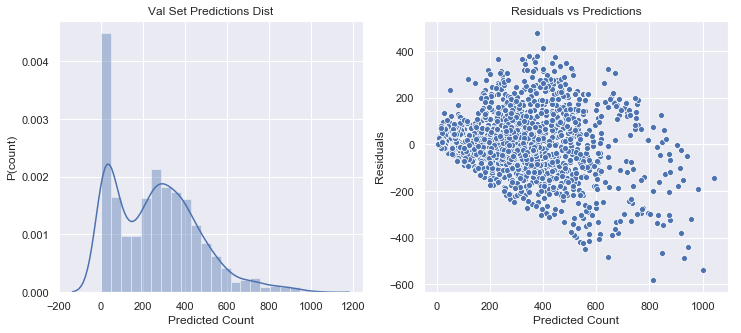

In [559]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 5)
sns.distplot(pred_lr, ax=axes[0])
axes[0].set(xlabel='Predicted Count', ylabel='P(count)', title='Val Set Predictions Dist' )

residuals = (y_val_lr - pred_lr)
sns.scatterplot(x=pred_lr, y=residuals, ax=axes[1])
axes[1].set(xlabel='Predicted Count', ylabel='Residuals', title='Residuals vs Predictions')

print('LINEAR REGRESSION WITH LOG TRANSFORMATION ON DATA')
print('MSLE: ', msle)

#### Plot Residuals vs Predictions - WITHOUT log transformation of Count

LINEAR REGRESSION WITHOUT LOG TRANSFORMATION ON DATA
MSLE: 0.9980210264360666


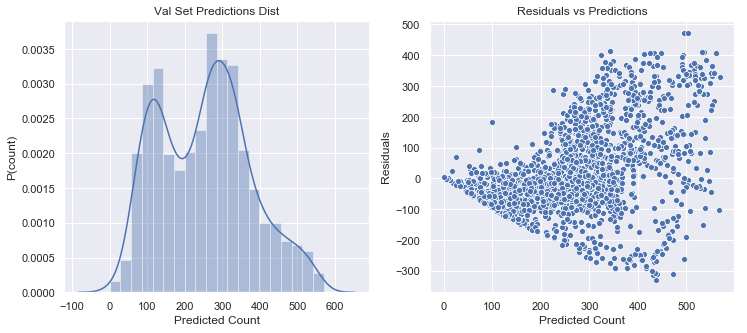

In [474]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 5)
sns.distplot(pred_lr, ax=axes[0])
axes[0].set(xlabel='Predicted Count', ylabel='P(count)', title='Val Set Predictions Dist' )

residuals = (y_val_lr - pred_lr)
sns.scatterplot(x=pred_lr, y=residuals, ax=axes[1])
axes[1].set(xlabel='Predicted Count', ylabel='Residuals', title='Residuals vs Predictions')

print('LINEAR REGRESSION WITHOUT LOG TRANSFORMATION ON DATA')
print('MSLE:', msle)

#### Analysis:

The following variations of the input data generated these results:
- Using Count instead of Log-Count provides a score of 0.99, which is almost double than the 0.56 obtained by fitting a model that predicts the log of Count. 
- Removing outliers negatively impacted the model performance. Therefore, we will keep outliers.
- Normalizing and Standardizing had no effect on the model. We will keep the original values.
- Not converting categorical variables into one-hot vectors doubled the error rate.

After choosing log(count) as the better independent variable:
1. The linear model does a good job at explaining the response variable Count, with an Adjusted R^2 score of 0.825.
2. Dropping those features with low predictive power (high p-values) did not result in any changes to the error rate or R^2 score, so we will keep them for simplicity.
3. The error score from regularized models (both L1 and L2) came up to be higher than with no regularization, so we will keep the unregularized model. 

    
**Note: Some of the predictions were negative. In reality we can't have negative bike rentals, so these values were substituted by zeros.**

#### From looking at the "Residuals vs Predictions" plots, we observe discernable patterns. This means not all of the non-random portion of the error is being captured. Let's try some non-linear models next and perform a similar analysis as above.

### Model B: Neural Network

In [548]:
# # Build Network
input_tensor = Input(shape=(X_train.shape[1],))
x = layers.Dense(80, activation='relu')(input_tensor)
x = layers.Dense(80, activation='relu')(x)
output_tensor = layers.Dense(1)(x)
nn_model = Model(input_tensor, output_tensor)
nn_model.summary()

# Compile and Fit
nn_model.compile(optimizer='rmsprop', loss='msle')
history = nn_model.fit(X_train, y_train, validation_split=0.2, epochs=10)
pred_nn = nn_model.predict(X_val)

# # Convert back from Log_Count to Count
# pred = exp_transform(pred)
# y_val = exp_transform(y_val)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 53)                0         
_________________________________________________________________
dense_61 (Dense)             (None, 80)                4320      
_________________________________________________________________
dense_62 (Dense)             (None, 80)                6480      
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 81        
Total params: 10,881
Trainable params: 10,881
Non-trainable params: 0
_________________________________________________________________
Train on 6966 samples, validate on 1742 samples
Epoch 1/10
6966/6966 [==============================] - 1s 211us/step - loss: 2.1208 - val_loss: 2.4419
Epoch 2/10
6966/6966 [==============================] - 0s 64us/step - loss: 2.1072 - val_loss: 2.5309
Epoch 3/10
6966

#### Plot Residuals vs Predictions

NEURAL NETWORKS MODEL RESULTS
MSLE:  1.333658125759546


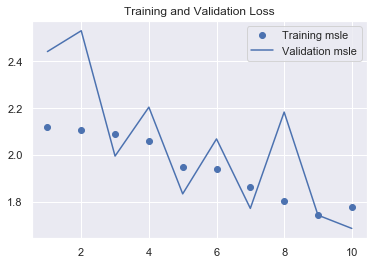

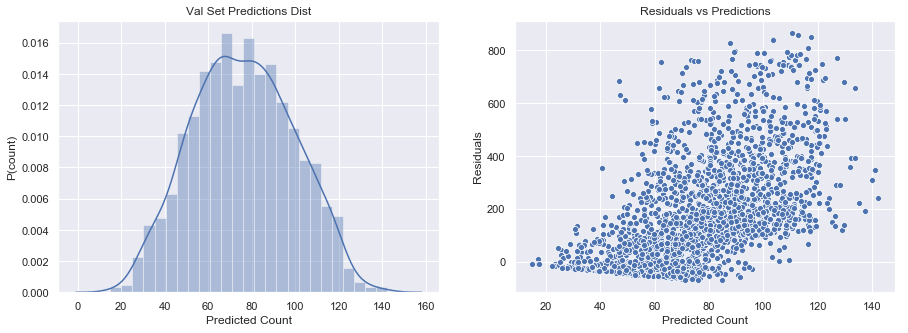

In [549]:
# Evaluate Model
pred_nn = np.ravel(pred_nn)
pred_nn[pred_nn<0] = 0
msle = np.sqrt(mean_squared_log_error(y_val, pred_nn))

# Plot Training and Validation MSLE
msle_train = history.history['loss']
msle_val = history.history['val_loss']
epochs = range(1, len(msle_train) + 1)
plt.figure()
plt.plot(epochs, msle_train, 'bo', label='Training msle')
plt.plot(epochs, msle_val, 'b', label='Validation msle')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Predictions and Residuals
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15, 5)

sns.distplot(pred_nn, ax=axes[0])
axes[0].set(xlabel='Predicted Count', ylabel='P(count)', title='Val Set Predictions Dist' )

residuals = (y_val - pred_nn)
sns.scatterplot(x=pred_nn, y=residuals, ax=axes[1])
axes[1].set(xlabel='Predicted Count', ylabel='Residuals', title='Residuals vs Predictions')

print('NEURAL NETWORKS MODEL RESULTS')
print('MSLE: ', msle)

**The results from our Neural Network are not great at all. Let's try some other models.**

### Model C: Random Forests

In [538]:
rfc = RandomForestRegressor(n_estimators = 50)
rfc.fit(X_train, y_train)
rfc.feature_importances_
pred_rf = rfc.predict(X_val)

# Evaluate Model on Validation Set
pred_rf.resize(y_val.shape)
mlse_rf = np.sqrt(mean_squared_log_error(y_val, pred_rf))

#### Plot Residuals vs Predictions

RANDOM FORESTS MODEL RESULTS
MSLE:  1.2280650533297208


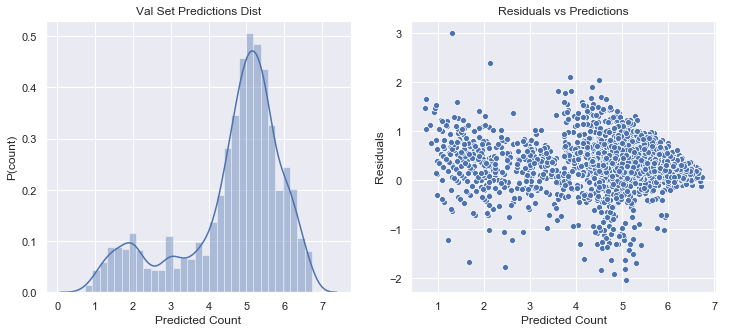

In [539]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 5)
sns.distplot(pred_rf, ax=axes[0])
axes[0].set(xlabel='Predicted Count', ylabel='P(count)', title='Val Set Predictions Dist' )

residuals = (y_val - pred_rf)
sns.scatterplot(x=pred_rf, y=residuals, ax=axes[1])
axes[1].set(xlabel='Predicted Count', ylabel='Residuals', title='Residuals vs Predictions')

print('RANDOM FORESTS MODEL RESULTS')
print('MSLE: ', msle)

### Model D: XGRegressor

In [9]:
xgr_params = [{'max_depth': [8], 'min_child_weight':[4], 'gamma':[0.0001]}] #per previous run

xgr = xg.XGBRegressor()

grid_xgr = GridSearchCV(xgr, param_grid=xgr_params, cv=5, refit=True, verbose=1)
grid_xgr.fit(X_train, y_train)
pred_xgr = grid_xgr.predict(X_val)

best_score = grid_xgr.best_score_
best_params = grid_xgr.best_params_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   34.7s finished


#### Plot Residuals vs Predictions

XGBOOST REGRESSOR WITHOUT LOG TRANSFORMATION MODEL RESULTS
MSLE:  0.6093859464940209


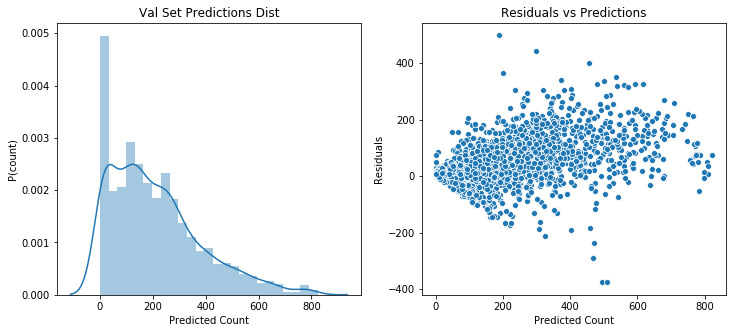

In [11]:
# Evaluate Model on Validation Set
pred_xgr[pred_xgr<0] = 0
msle_xgr = np.sqrt(mean_squared_log_error(y_val, pred_xgr))

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 5)
sns.distplot(pred_xgr, ax=axes[0])
axes[0].set(xlabel='Predicted Count', ylabel='P(count)', title='Val Set Predictions Dist' )

residuals = (y_val - pred_xgr)
sns.scatterplot(x=pred_xgr, y=residuals, ax=axes[1])
axes[1].set(xlabel='Predicted Count', ylabel='Residuals', title='Residuals vs Predictions')

print('XGBOOST REGRESSOR WITHOUT LOG TRANSFORMATION MODEL RESULTS')
print('MSLE: ', msle_xgr)

### Model E: Ensemble Gradient Boosting

In [81]:
egb_params = [{'learning_rate': [0.1], 'max_depth':[6]}] # from previous run

egb = GradientBoostingRegressor(n_estimators=50, loss='ls')

grid_egb = GridSearchCV(egb, param_grid=xgforest_params, cv=5, refit=True, verbose=1)
grid_egb.fit(X_train, y_train)
best_score = grid_egb.best_score_
best_params = grid_egb.best_params_
print(' The Best Score :', best_score, '\n', 'The Best Params : ', best_params)
pred_egb = grid_egb.predict(X_val)
pred_egb[pred_egb<0] = 0

# Evaluate Model on Validation Set
# pred.resize(y_val_xg.shape)
msle_egb = np.sqrt(mean_squared_log_error(y_val, pred_egb))
print('MSLE Score: ', msle_egb)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.4s finished


 The Best Score : 0.7976643402785151 
 The Best Params :  {'learning_rate': 0.1, 'max_depth': 6}
MSLE Score:  0.1154609577190961


#### Plot Residuals vs Predictions

XGBOOST REGRESSOR WITH LOG TRANSFORMATION MODEL RESULTS
MSLE:  0.11240912002474802


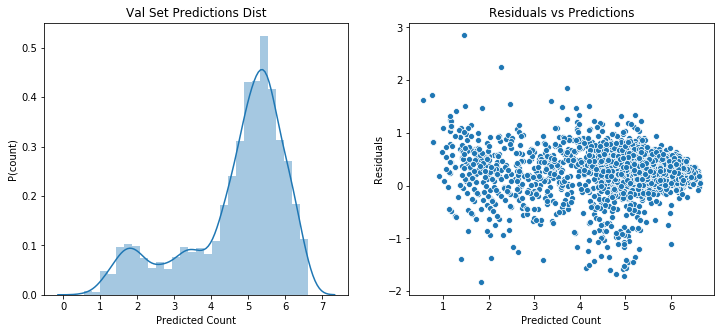

In [80]:
# Evaluate Model on Validation Set
pred_egb[pred_egb<0] = 0
msle_egb = np.sqrt(mean_squared_log_error(y_val, pred_egb))

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 5)
sns.distplot(pred_egb, ax=axes[0])
axes[0].set(xlabel='Predicted Count', ylabel='P(count)', title='Val Set Predictions Dist' )

residuals = (y_val - pred_xgf)
sns.scatterplot(x=pred_egb, y=residuals, ax=axes[1])
axes[1].set(xlabel='Predicted Count', ylabel='Residuals', title='Residuals vs Predictions')

print('ENSEMBLE GRADIENT BOOSTING WITH LOG TRANSFORMATION MODEL RESULTS')
print('MSLE: ', msle_egb)

### [Extra] Model F: Recurrent Neural Network (RNN) and Additinoal Feature Engineering

I tried a couple of other models just to see what kind of results they would give. They weren't great, but if you're interested here I describe both:

1. **RNN** - A rolling model that used data from the previous 24 hours to predict Count. It incorporated the Count variable from those 24 hours. Therefore, when it got to the 20th day of the month, it took data from day 19. This meant, however, that on day 21 it used data from day 20, which were all predictions obtained previously. The Count predictions ended up being too low. My hypothesis is that the RNN model (which used GRU cells) assigned heavy neuron weights on the Count input from the previous 24 hours because it was a strong predictor, but it got stuck predicting values very similar to the previous Counts. This, as we saw in our EDA, is not a behavior observed on the data.
2. **Additional Feature** - Similarly to above, I incorporated Count from previous observations and used XGBoost. The model used Count from exactly 24 hours earlier (same time, previous day), but just that one Count value, not a window of 24 observations as in the RNN model above. To predict on the test set it used data from the training set only for day 20. Day 21 used the predictions from day 20, and so on. Therefore it resulted in a similar pattern as the RNN model: relying too heavily on the Count_From_24_Hours_Ago feature and then getting stuck on very similar values. This could be circumvented in various ways. One would be to heavily regulate the weight for that particular input, for instance.

#### With all this in mind, let's move on to the final results...

## 5. Generate Results and Export Models
Based on the 7 models attempted, and their set of variations, Linear Regression and Ensemble Gradient Boosting performed best. Therefore, we will submit results for those two models and cross our fingers (that's important, don't forget the cross-fingers step).

In order to produce the final results, we need to do one last thing: **train the models on the entire training set**. So far we have been using a subset of it, so that we could use the remaining portion (20%) for validation. So let's train Linear Regression and Ensemble Gradient Boosting on the entire set.

In [82]:
# Concatenate train and validation sets into one
X_train_all = pd.concat([X_train, X_val], axis=0)
y_train_all = pd.concat([y_train, y_val], axis=0)

### 5.1 Linear Regression on Whole Training Set
Code to perform linear regression on entire training set.

In [27]:
X_train_lr_all = sm.add_constant(X_train_all, has_constant='add')
test_df_lr = sm.add_constant(test_df, has_constant='add')
est = sm.OLS(y_train_all, X_train_lr_all) 
est2 = est.fit()
pred_lr = est2.predict(test_df_lr)

# Convert back from Log_Count to Count
pred_lr = exp_transform(pred_lr)
pred_lr[pred_lr<0] = 0

### 5.2 Ensemble Gradient Boosting on Whole Training Set
Code to perform Ensemble Gradient Boosting on entire training set.

In [97]:
egb_params = [{'learning_rate': [0.1], 'max_depth':[6]}] # from previous run

egb = GradientBoostingRegressor(n_estimators=250, loss='ls')
grid_egb = GridSearchCV(egb, param_grid=egb_params, verbose=1)
grid_egb.fit(X_train_all, y_train_all)

pred_egb = grid_egb.predict(test_df)
pred_egb = exp_transform(pred_egb)
pred_egb[pred_egb<0] = 0

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.7s finished


### 5.3 Save Files with Final Predictions on Test Set
Code to save files with final predictions.

In [98]:
# Make a copy of the sample submission file for each model
# submission_LR = sample_submission.copy()
submission_EGB = sample_submission.copy()

# Add predictions to submission file
# submission_LR['count'] = np.array(pred_lr)
submission_EGB['count'] = pred_egb

# Save Files
# submission_LR.to_csv('submission_LR', header=True, index=False)
submission_EGB.to_csv('submission_EGB', header=True, index=False)

## Final Results

#### Combine Count for train and test sets to plot a rolling sum of rentals over the entire period

In [8]:
submission_EGB = pd.read_csv('submission_EGB')

In [12]:
train_count = pd.DataFrame(train_df['count'])
train_count['train/test'] = 'train set'
#submission_EGB['datetime'] = submission_EGB['datetime'].apply(lambda x:datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
submission_EGB['train/test'] = 'predictions'
train_count.reset_index(inplace=True)
all_count = pd.concat([train_count, submission_EGB], axis=0)
all_count.sort_values('datetime', axis=0)
print('Done')

Done


(734128.0, 734878.9583333334)

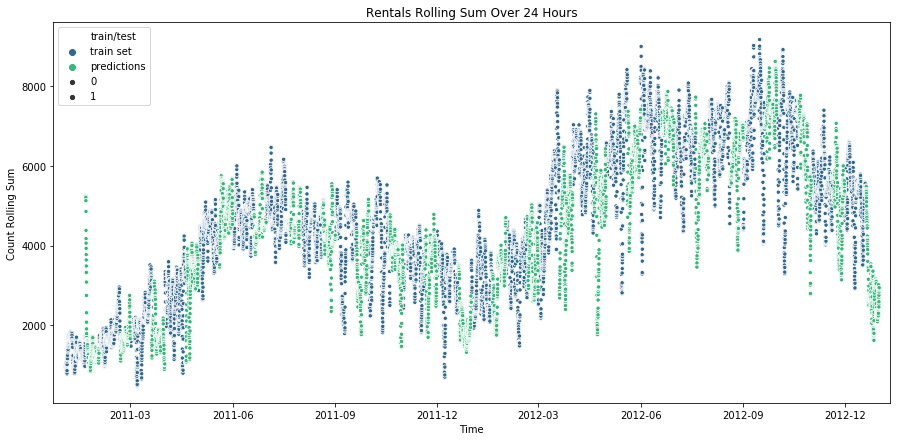

In [13]:
# Plot Rentals Rolling Sum Combining the Training and Test Sets Data
fig,ax = plt.subplots()
fig.set_size_inches(15,7)
sns.scatterplot(x = all_count['datetime'], y = all_count['count'].rolling(24).sum(), size=1, hue=all_count['train/test'],
               palette='viridis')
ax.set(ylabel='Count Rolling Sum', xlabel='Time', title='Rentals Rolling Sum Over 24 Hours')
ax.set_xlim(all_count['datetime'].min() - timedelta(hours=240), all_count['datetime'].max()+timedelta(hours=240))

The plot shows predictions to be well within what we would expect based on the trends in the training set. 

After submitting both models to Kaggle, Ensemble Gradient Boosting with log-transformed Count had the lowest error rate at 0.43. This could be improved further by increasing the number of estimators and exploring other values for its parameters (we tested only a few combinations with GridSearchCV).

A shout out to Vivek Srinivasan and his Kernel "EDA & Ensemble Model (Top 10 Percentile)". It provided great insights that helped me structure my EDA. 

### Kindly share if you found this useful.